In [8]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict

# ----------- State Definitions -----------
class NewsState(TypedDict):
    articles: List[Dict]
    categorized: List[Dict]
    summaries: List[Dict]

class UserState(TypedDict):
    user_id: str
    summaries: List[Dict]        # loaded from preprocessing
    personalized: List[Dict]
    feedback: Dict

# ----------- Preprocessing Pipeline (Independent of User) -----------
def fetch_news(state: NewsState) -> NewsState:
    # Dummy articles (replace with NewsAPI/RSS)
    articles = [
        {"title": "AI beats humans in coding contest", "content": "OpenAI model wins..."},
        {"title": "India wins cricket test series", "content": "Exciting match highlights..."},
        {"title": "Stock markets hit record high", "content": "Investors cheer as..."}
    ]
    state["articles"] = articles
    return state

def categorize(state: NewsState) -> NewsState:
    categorized = []
    for article in state["articles"]:
        if "cricket" in article["title"].lower():
            article["category"] = "Sports"
        elif "stock" in article["title"].lower():
            article["category"] = "Finance"
        else:
            article["category"] = "Technology"
        categorized.append(article)
    state["categorized"] = categorized
    return state

def summarize(state: NewsState) -> NewsState:
    summaries = []
    for article in state["categorized"]:
        summary = f"{article['title']} - {article['content'][:40]}..."
        summaries.append({**article, "summary": summary})
    state["summaries"] = summaries
    return state

# ----------- User Pipeline (Dependent on User) -----------
def load_summaries(state: UserState, shared_summaries: List[Dict]) -> UserState:
    state["summaries"] = shared_summaries
    return state

def personalize(state: UserState) -> UserState:
    # Example personalization (could use embeddings + memory)
    priority = {"Technology": 1, "Sports": 2, "Finance": 3}
    personalized = sorted(state["summaries"], key=lambda x: priority[x["category"]])
    state["personalized"] = personalized
    return state

def hitl_feedback(state: UserState) -> UserState:
    # Simulated HITL feedback
    feedback = {
        "liked": [state["personalized"][0]["title"]],
        "disliked": [state["personalized"][-1]["title"]]
    }
    state["feedback"] = feedback
    return state

# ----------- Build Preprocessing Graph -----------
pre_graph = StateGraph(NewsState)
pre_graph.add_node("fetch_news", fetch_news)
pre_graph.add_node("categorize", categorize)
pre_graph.add_node("summarize", summarize)

pre_graph.set_entry_point("fetch_news")
pre_graph.add_edge("fetch_news", "categorize")
pre_graph.add_edge("categorize", "summarize")
pre_graph.add_edge("summarize", END)

pre_app = pre_graph.compile()

# ----------- Build User Graph -----------
user_graph = StateGraph(UserState)
user_graph.add_node("load_summaries", lambda s: load_summaries(s, shared_summaries))
user_graph.add_node("personalize", personalize)
user_graph.add_node("hitl_feedback", hitl_feedback)

user_graph.set_entry_point("load_summaries")
user_graph.add_edge("load_summaries", "personalize")
user_graph.add_edge("personalize", "hitl_feedback")
user_graph.add_edge("hitl_feedback", END)

# Compile later after preprocessing

if __name__ == "__main__":
    # Run preprocessing (independent)
    pre_result = pre_app.invoke({})
    shared_summaries = pre_result["summaries"]

    print("✅ Preprocessed News Summaries:\n")
    for art in shared_summaries:
        print(f"[{art['category']}] {art['summary']}")

    # Now build user-specific graph with shared_summaries
    user_app = user_graph.compile()
    user_result = user_app.invoke({"user_id": "user123"})

    print("\n🎯 Personalized Feed for user123:\n")
    for art in user_result["personalized"]:
        print(f"[{art['category']}] {art['summary']}")

    print("\nUser Feedback:", user_result["feedback"])


✅ Preprocessed News Summaries:

[Technology] AI beats humans in coding contest - OpenAI model wins......
[Sports] India wins cricket test series - Exciting match highlights......
[Finance] Stock markets hit record high - Investors cheer as......

🎯 Personalized Feed for user123:

[Technology] AI beats humans in coding contest - OpenAI model wins......
[Sports] India wins cricket test series - Exciting match highlights......
[Finance] Stock markets hit record high - Investors cheer as......

User Feedback: {'liked': ['AI beats humans in coding contest'], 'disliked': ['Stock markets hit record high']}


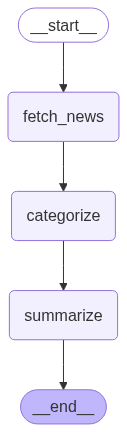

In [9]:
from IPython.display import Image, display

try:
    display(Image(pre_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

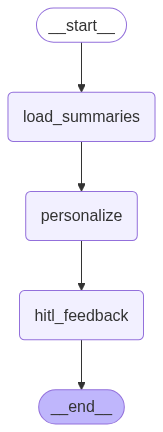

In [6]:
from IPython.display import Image, display

try:
    display(Image(user_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)